In [2]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np
import cupy as cp
import cv2

In [3]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(1)

# Model definition

In [4]:
env_x = [-2,10]
env_y = [-1,1]
points_per_unit = 30

width = ((env_x[1] - env_x[0]) * points_per_unit) + 1
height = ((env_y[1] - env_y[0]) * points_per_unit) + 1

env_shape = [height, width]
state_count = width * height
print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: [61, 361]
State count: 22021


In [5]:
# Data loading
nose_data = pd.read_csv('./Data/statistics_abs_nose_3e6.dat', sep=' ', skiprows=[0], names=list(range(320)), index_col=False).to_numpy().T
ground_data = pd.read_csv('./Data/statistics_abs_ground_3e6.dat', sep=' ', skiprows=[0], names=list(range(320)), index_col=False).to_numpy().T

nose_data = cv2.resize(nose_data, dsize=((4 * points_per_unit) + 1, points_per_unit + 1))
ground_data = cv2.resize(ground_data, dsize=((4 * points_per_unit) + 1, points_per_unit + 1))

nose_data_padded = np.zeros(env_shape)
nose_data_padded[15:46, 60:181] = nose_data

ground_data_padded = np.zeros(env_shape)
ground_data_padded[15:46, 60:181] = ground_data

nose_data = nose_data_padded
ground_data = ground_data_padded

In [6]:
# goal state
goal_state_coords = [30,60]
goal_state = (goal_state_coords[0] * env_shape[1]) + goal_state_coords[1]

print(f'Goal state: {goal_state}')

Goal state: 10890


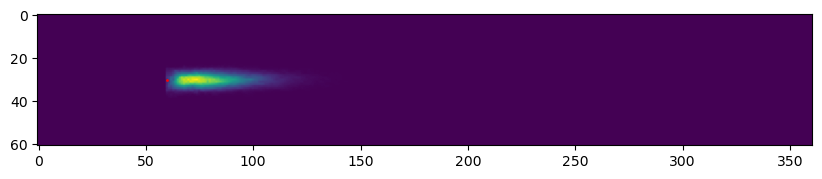

In [7]:
plt.figure(figsize=(10,20))
plt.imshow(ground_data)
plt.scatter(goal_state_coords[1], goal_state_coords[0], c='red',s=1)

In [8]:
# observation matrix
observations = np.empty((state_count, 6, 3)) # 6-actions, 3-observations

# obs 0: Nothing observed, obs 1: Something observed, obs 2: source found

observations[:,:5,0] = (1 - ground_data.ravel()[:,None])
observations[:,:5,1] = ground_data.ravel()[:,None]

observations[:,5,0] = (1 - nose_data.ravel())
observations[:,5,1] = nose_data.ravel()

# Detection of goal
observations[:,:,2] = 0.0
observations[goal_state,:,:] = 0.0
observations[goal_state,:,2] = 1.0

In [9]:
# states
state_grid = []

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [10]:
# Reachable states
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 6, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West
    reachable_states[s,4,0] = s # Doesn't move and sniff ground
    reachable_states[s,5,0] = s # Doesn't move and sniff air

reachable_states = np.array(reachable_states)

In [11]:
# Reward function
def reward_func(s,a,sn,o):
    return np.where(sn == goal_state, 1.0, 0.0)

In [12]:
# Start belief
start = np.zeros(env_shape)
start[15:46,60:316] = 1.0
start /= np.sum(start)

In [13]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W','O_Ground','O_Air'],
    observations=['nothing','something','goal'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[goal_state],
    start_probabilities=start.ravel()
)

[11/15/2023, 14:43:23] Instantiation of MDP Model:
[11/15/2023, 14:43:23] - 22021 states
[11/15/2023, 14:43:23] - 6 actions
[11/15/2023, 14:43:23] - At most 1 reachable states per state-action pair
[11/15/2023, 14:43:23] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[11/15/2023, 14:43:23]     > Done in 0.000s
[11/15/2023, 14:43:23] - Generation of state grid
[11/15/2023, 14:43:23] - Generating start probabilities table
[11/15/2023, 14:43:23] - Starting computation of reachable state probabilities from transition data
[11/15/2023, 14:43:23]     > Done in 0.000s
[11/15/2023, 14:43:23] POMDP particular parameters:
[11/15/2023, 14:43:23] - 3 observations
[11/15/2023, 14:43:23] - Starting of transitional observations for reachable states table
[11/15/2023, 14:43:23]     > Done in 0.007s
[11/15/2023, 14:43:23] - Starting gene

# MDP solving

In [13]:
from src.mdp import VI_Solver

In [14]:
solver = VI_Solver(eps=1e-4)

In [15]:
mdp_solution, history = solver.solve(model, use_gpu=True)
print(history.summary)

[11/14/2023, 16:23:43] Sending Model to GPU...
[11/14/2023, 16:23:43]     > Done in 0.263s


  0%|          | 0/10000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 22021-state, 6-action
  - Converged in 460 iterations and 0.5860 seconds
  - Took on average 0.0013s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


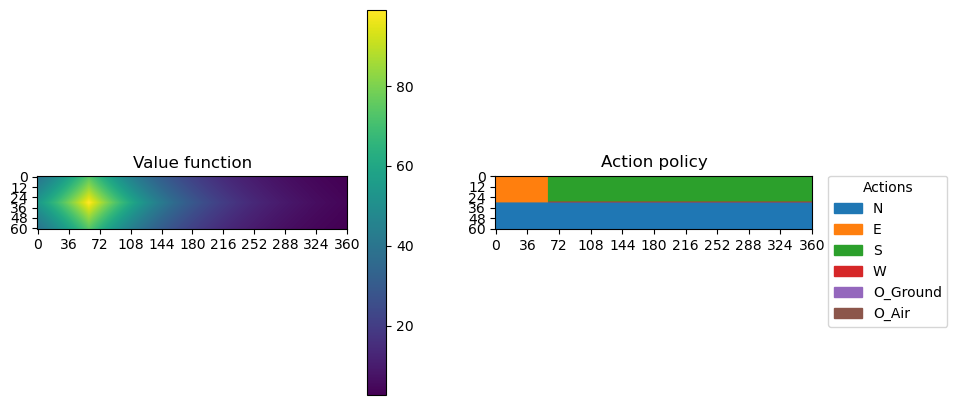

In [16]:
mdp_solution.plot()

# FSVI Solving

In [17]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [18]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=300,
                                        horizon=100,
                                        mdp_policy=mdp_solution,
                                        belief_memory_depth=10,
                                        # prune_level=2, # Useless because of belief domination
                                        # prune_interval=25,
                                        # history_tracking_level=2,
                                        use_gpu=True)
print(hist.summary)

Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

[11/14/2023, 16:23:44] Horizon reached before goal...
[11/14/2023, 16:23:45] Horizon reached before goal...
[11/14/2023, 16:23:45] Horizon reached before goal...
[11/14/2023, 16:23:45] Horizon reached before goal...
[11/14/2023, 16:23:45] Horizon reached before goal...
[11/14/2023, 16:23:46] Horizon reached before goal...
[11/14/2023, 16:23:46] Horizon reached before goal...
[11/14/2023, 16:23:46] Horizon reached before goal...
[11/14/2023, 16:23:46] Horizon reached before goal...
[11/14/2023, 16:23:46] Horizon reached before goal...
[11/14/2023, 16:23:46] Horizon reached before goal...
[11/14/2023, 16:23:47] Horizon reached before goal...
[11/14/2023, 16:23:47] Horizon reached before goal...
[11/14/2023, 16:23:47] Horizon reached before goal...
[11/14/2023, 16:23:47] Horizon reached before goal...
[11/14/2023, 16:23:47] Horizon reached before goal...
[11/14/2023, 16:23:47] Horizon reached before goal...
[11/14/2023, 16:23:47] Horizon reached before goal...
[11/14/2023, 16:23:48] Horiz

In [19]:
fsvi_solution.save()

# Loading fsvi solution

In [14]:
fsvi_solution = ValueFunction.load_from_file('./ValueFunctions/20231114_fsvi_g0.99_i300_e100_value_function.csv', model).to_gpu()

[11/15/2023, 14:44:40] Sending Model to GPU...
[11/15/2023, 14:44:41]     > Done in 0.212s


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


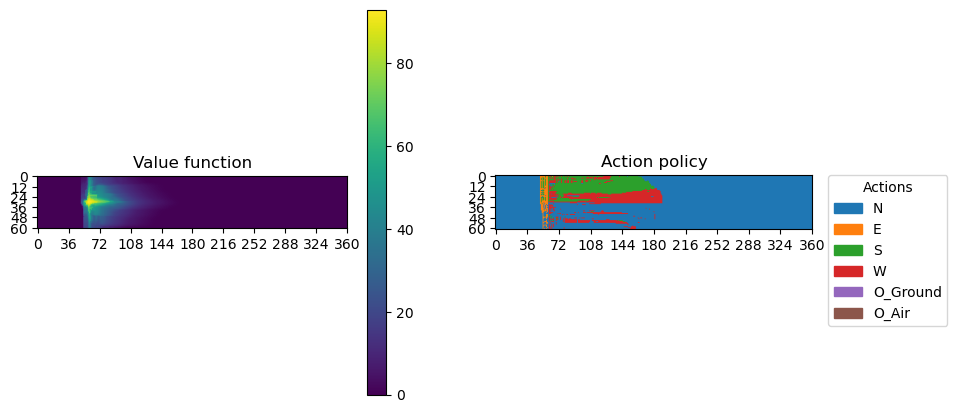

In [15]:
fsvi_solution.plot()

# Sim

In [27]:
a = Agent(model=model, value_function=fsvi_solution.to_cpu())

In [28]:
sim_hist = a.simulate(start_state=(env_shape[1]*30)+300)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 15.52186
	- Steps: 476
	- Total rewards: 1.0
	- End state: s_30_60


In [26]:
for o in sim_hist.model.observations:
    print(type(o))
    break

<class 'cupy.ndarray'>


In [29]:
# sim_hist.save_simulation_video()

Video saved at 'Sim Videos/s22021-a6-20231114_163420.mp4'...


# Sim plot

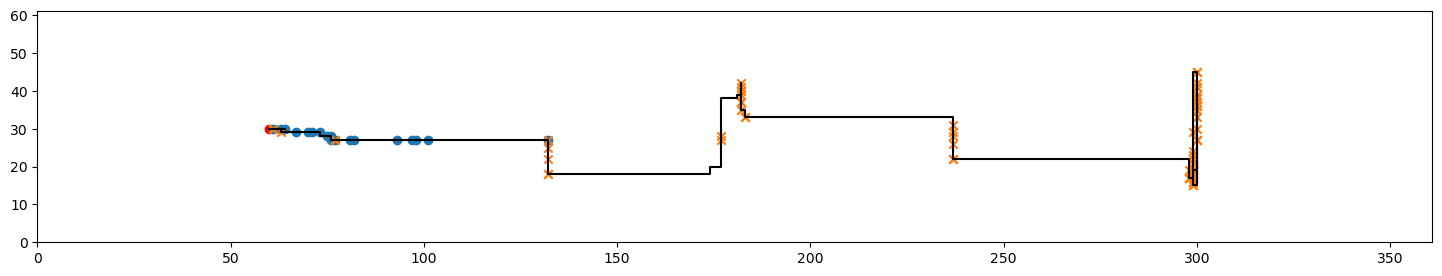

In [60]:
# PLot setup
plt.figure(figsize=(18,3))
plt.xlim(0, env_shape[1])
plt.ylim(0, env_shape[0])

# Goal
plt.scatter(60, 30, c='red')

# Path
seq = np.array(sim_hist.grid_point_sequence)
plt.plot(seq[:,1], seq[:,0], c='black')

# Something sensed
obs_ts = np.where(np.array(sim_hist.observations) == 1)
points_obs = seq[obs_ts[0],:]
plt.scatter(points_obs[:,1], points_obs[:,0])

# Points sniff
sniff_in_air = np.where(np.array(sim_hist.actions) == 5)
points_sniff = seq[sniff_in_air[0],:]
plt.scatter(points_sniff[:,1], points_sniff[:,0], marker='x')

# Entropy-value plot

In [62]:
from scipy.stats import entropy

In [64]:
ents = [entropy(b.values) for b in sim_hist.beliefs]

In [89]:
b_array = cp.array([(b.values) for b in sim_hist.beliefs])
b_vals = cp.asnumpy(cp.max(cp.matmul(fsvi_solution.alpha_vector_array, b_array.T), axis=0))

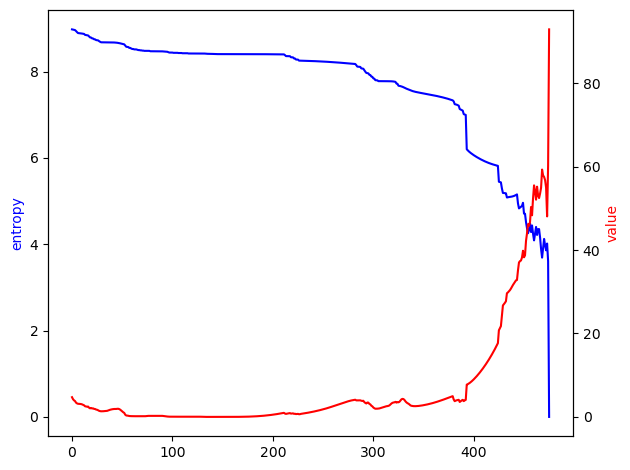

In [93]:
fig, ax1 = plt.subplots()

# Entropy
ax1.plot(np.arange(len(ents)), ents, color='blue')
ax1.set_ylabel('entropy', color='blue')

ax2 = ax1.twinx()

ax2.plot(np.arange(len(b_vals)), b_vals, color='red')
ax2.set_ylabel('value', color='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Multiple simulations

In [16]:
a = Agent(model, fsvi_solution)

In [17]:
# On center line
_, sim_set = a.run_n_simulations(n=100, start_state=(env_shape[1]*30)+300)

  0%|          | 0/100 [00:00<?, ?it/s]

All 100 simulations done:
	- Average runtime (s): 0.59715723
	- Average step count: 477.75
	- Average total rewards: 1.0
	- Average discounted rewards (ADR): 0.008458535758317122


# Extra steps needed

In [18]:
sim_lengths = [len(sim) for sim in sim_set]

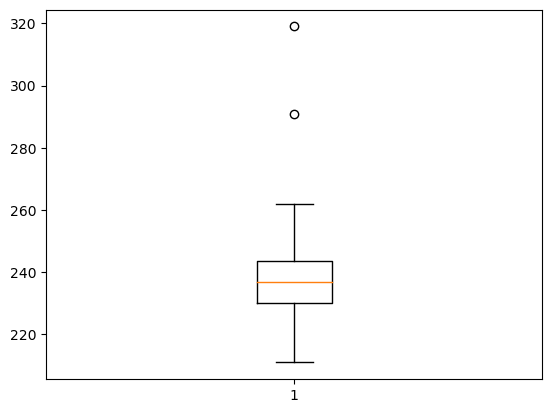

In [20]:
plt.boxplot(np.array(sim_lengths)-240)
plt.show()

# Sniff in air clos vs far

In [21]:
close_points = np.where(nose_data.ravel() > 0)[0]

In [22]:
close_rates = []
far_rates = []
for sim in sim_set:
    close_sniff_air = 0
    close_steps = 0

    far_sniff_air = 0
    far_steps = 0
    for s,a in zip(sim.states[1:], sim.actions):
        if s in close_points:
            close_steps += 1
            if a == 5:
                close_sniff_air +=1
        else:
            far_steps += 1
            if a == 5:
                far_sniff_air += 1

    close_rates.append(close_sniff_air / close_steps)
    far_rates.append(far_sniff_air / far_steps)

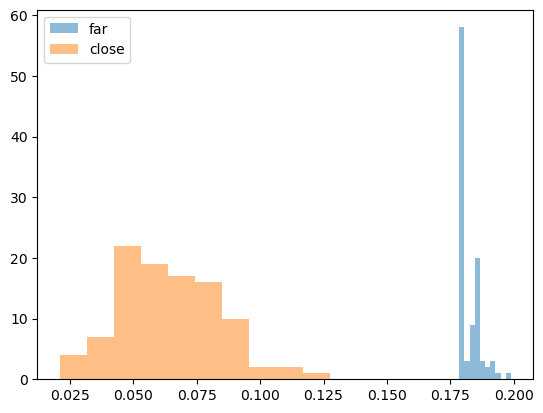

In [23]:
plt.hist(far_rates, alpha=0.5, label='far')
plt.hist(close_rates, alpha=0.5, label='close')
plt.legend()
plt.show()

# Cast/surge rates

In [56]:
surge_rates = []
cast_rates = []

for sim in sim_set:

    # Cast action: 0 or 2
    is_action = np.where((np.array(sim.actions) == 0) | (np.array(sim.actions) == 2) | (np.array(sim.actions) == 5), 1, 0)
    is_action_seq = is_action[:-2] + is_action[1:-1] + is_action[2:]
    cast_sequence = np.zeros(len(sim), dtype=bool)

    for i, el in enumerate(is_action_seq):
        if el == 3:
            cast_sequence[i:i+3] = True

    cast_count = np.sum(cast_sequence[:-1])
    cast_sniff = np.sum(cast_sequence[:-1] & (np.array(sim.actions) == 5))
    cast_rates.append(cast_sniff / cast_count)

    # Surge action: 3
    is_action = np.where((np.array(sim.actions) == 3) | (np.array(sim.actions) == 5), 1, 0)
    is_action_seq = is_action[:-2] + is_action[1:-1] + is_action[2:]
    surge_sequence = np.zeros(len(sim), dtype=bool)

    for i, el in enumerate(is_action_seq):
        if el == 3:
            surge_sequence[i:i+3] = True

    surge_count = np.sum(surge_sequence[:-1])
    surge_sniff = np.sum(surge_sequence[:-1] & (np.array(sim.actions) == 5))
    surge_rates.append(surge_sniff / surge_count)

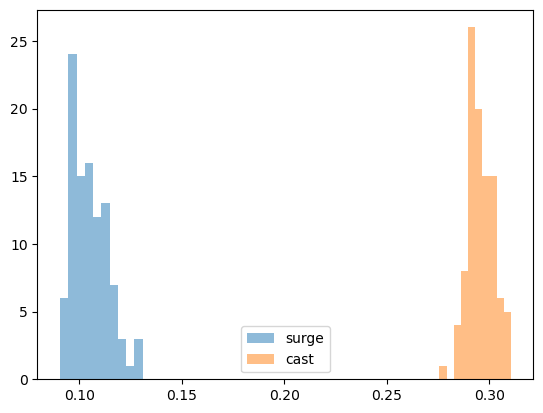

In [57]:
plt.hist(surge_rates, alpha=0.5, label='surge')
plt.hist(cast_rates, alpha=0.5, label='cast')
plt.legend()
plt.show()

In [ ]:
# above center line
# _, sim_set = a.run_n_simulations(n=100, start_state=(env_shape[1]*15)+300)

In [ ]:
# below center line
# _, sim_set = a.run_n_simulations(n=100, start_state=(env_shape[1]*45)+300)